# **Import packages**

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.7 MB/s 
     |████████████████████████████████| 212 kB 62.1 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

# **Load Data**

In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
print(len(train))
print(len(val))
print(len(test))

16000
2000
2000


In [ ]:
def get_tweets(data):
  tweets = data['text']
  labels = data['label']
  return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

# **Data Preprocessing**

## **Tokenizer**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## **Padding and Truncating Sequences**

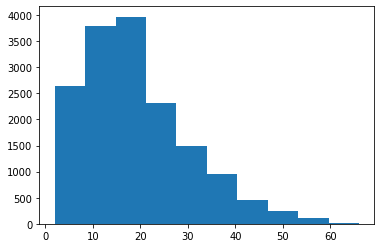

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths)
plt.show()

We can clearly see that we have the longest word about 50 or 60 words long. So, we will use that value to truncate and pad the sequences.

In [ ]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = "post", padding = "post", maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
padded_train_seq

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]], dtype=int32)

## **Preparing the Labels**

In [ ]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [ ]:
from collections import Counter
Counter(labels)

Counter({'sadness': 4666,
         'anger': 2159,
         'love': 1304,
         'surprise': 572,
         'fear': 1937,
         'joy': 5362})

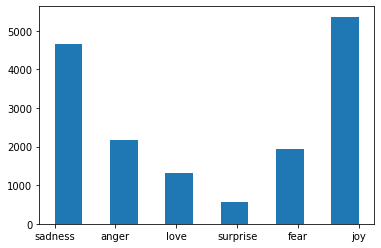

In [ ]:
plt.hist(labels, bins = 11)
plt.show()

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
print(class_to_index)
print(index_to_class)

{'fear': 0, 'surprise': 1, 'sadness': 2, 'love': 3, 'joy': 4, 'anger': 5}
{0: 'fear', 1: 'surprise', 2: 'sadness', 3: 'love', 4: 'joy', 5: 'anger'}


In [ ]:
name_to_idx = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = name_to_idx(labels)

In [ ]:
train_labels[0]

2

In [ ]:
train_labels

array([2, 2, 5, ..., 4, 5, 2])

## **Create The Model**

In [ ]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Embedding(10000, 32, input_length = maxlen),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(6, activation = 'softmax')
        ])
            
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            320000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 32)           6272      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 343,302
Trainable params: 343,302
Non-trainable params: 0
_________________________________________________________________


# **Training The Model**

In [ ]:
val_tweets, val_labels = get_tweets(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = name_to_idx(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [ ]:
models = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)]
)

Epoch 1/20
500/500 [==============================] - 16s 15ms/step - loss: 1.1491 - accuracy: 0.5564 - val_loss: 0.6799 - val_accuracy: 0.7745
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.4418 - accuracy: 0.8483 - val_loss: 0.4447 - val_accuracy: 0.8480
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2626 - accuracy: 0.9146 - val_loss: 0.3779 - val_accuracy: 0.8750
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1867 - accuracy: 0.9389 - val_loss: 0.3807 - val_accuracy: 0.8695
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1347 - accuracy: 0.9561 - val_loss: 0.3400 - val_accuracy: 0.8880
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1063 - accuracy: 0.9658 - val_loss: 0.3342 - val_accuracy: 0.8975
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.0875 - accuracy: 0.9727 - val_loss: 0.3198 - val_accuracy: 0.901

# **Evaluate the Model**

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

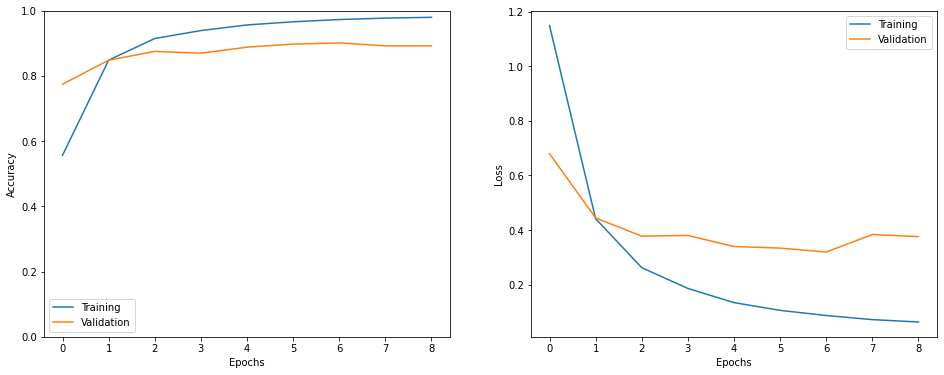

In [ ]:
show_history(models)

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = name_to_idx(test_labels)

In [ ]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.3772 - accuracy: 0.8895


[0.37723395228385925, 0.8895000219345093]

In [ ]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis = 0))
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i want to feel assured that my life will be good and i know it will be when i trust the lord
Emotion: joy
1/1 [==============================] - 1s 1s/step
Predicted Emotion: joy


In [ ]:
preds = model.predict(test_seq)
preds = np.argmax(preds, axis=1)
preds

63/63 [==============================] - 0s 6ms/step


array([2, 2, 2, ..., 4, 4, 1])

In [ ]:
from sklearn.metrics import confusion_matrix as cm
cmat = cm(test_labels, preds)
cmat

array([[191,  12,   8,   0,   3,  10],
       [ 15,  44,   1,   0,   6,   0],
       [  4,   1, 530,   0,  28,  18],
       [  1,   0,   1, 109,  46,   2],
       [  5,   5,   1,  24, 657,   3],
       [ 13,   0,  10,   0,   4, 248]])

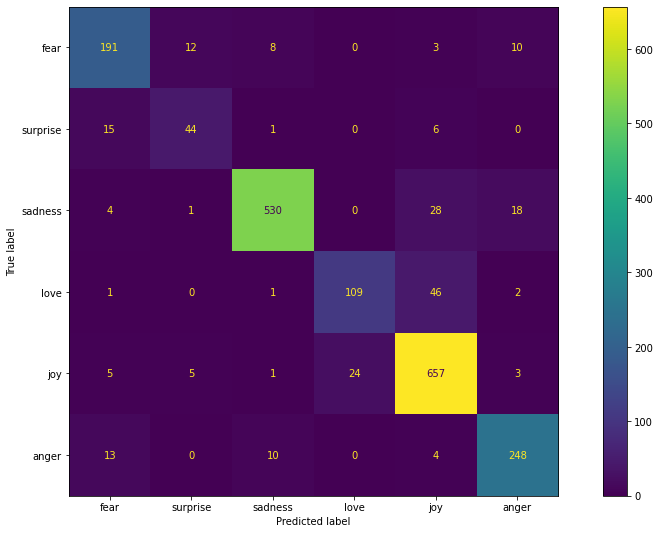

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

plt.rcParams['figure.figsize']=[16,9]
cmd_sm = ConfusionMatrixDisplay(cmat, display_labels = list(classes))
cmd_sm.plot() 

In [ ]:
from sklearn.metrics import classification_report as cr
print(cr(test_labels, preds))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       224
           1       0.71      0.67      0.69        66
           2       0.96      0.91      0.94       581
           3       0.82      0.69      0.75       159
           4       0.88      0.95      0.91       695
           5       0.88      0.90      0.89       275

    accuracy                           0.89      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
{'fear': 0, 'surprise': 1, 'sadness': 2, 'love': 3, 'joy': 4, 'anger': 5}